# **LeNet5 Model Implementation**

by: 
*   Cabo, Elias Ezar
*   Sabarre, Christian
*   Salibio, John Paul
*   Villegas, Lex


In [ ]:
import codecs
import os
import zipfile as zp
import requests
import shutil 
import gzip
import struct
import numpy as np
import matplotlib.pyplot as plt
import string
import random
import tensorflow as tf
import cv2 as cv
import pandas as pd

In [ ]:
# Dataset Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
base_dir = '/content/elec3_dataset'
zip_file = 'gzip.zip'
gzipFldr_path = os.path.join(base_dir, 'gzip')

try:
  os.mkdir(base_dir)
except:
  pass

### Fetch and unzip the EMNIST dataset using the link provided

In [ ]:
url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
r = requests.get(url, allow_redirects=True)
opn_zipFile = open(os.path.join(base_dir, zip_file), 'wb')
opn_zipFile.write(r.content)

561753746

In [ ]:
with zp.ZipFile(os.path.join(base_dir, zip_file), 'r') as zip_ref:
    zip_ref.extractall(base_dir)

### Define Functions

In [ ]:
def read_idx(file):
  print('Processing data from %s.' % file)
  with gzip.open(file, 'rb') as f:
    z, dtype, dim = struct.unpack('>HBB', f.read(4))
    print('Dimensions: ', dim)
    shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dim))
    print("Shape: ", shape)
    return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [ ]:
def load_mnist(dl_path):
  train_images = os.path.join(dl_path, 'emnist-letters-train-images-idx3-ubyte.gz')
  train_labels = os.path.join(dl_path, 'emnist-letters-train-labels-idx1-ubyte.gz')
  test_images = os.path.join(dl_path, 'emnist-letters-test-images-idx3-ubyte.gz')
  test_labels = os.path.join(dl_path, 'emnist-letters-test-labels-idx1-ubyte.gz')

  train_x = read_idx(train_images)
  train_y = read_idx(train_labels)

  test_x = read_idx(test_images)
  test_y = read_idx(test_labels)

  return (train_x, train_y, test_x, test_y)

In [ ]:
def show_shapes(x1, y1, x2, y2, digit = True):
    n = 'Digit' if digit else 'Alphabet'

    print('Mnist ', n, ' Dataset shapes: ')
    print('train X: ', x1.shape)
    print('train Y: ', y1.shape)
    print('test X: ', x2.shape)
    print('test Y: ',y2.shape)

In [ ]:
def transpose_image(data):
    out = [j for j in range(len(data))]
    for i in range(len(data)):
        out[i] = data[i].T

    return np.array(out)

In [ ]:
def show_data(image,label, digit = True):
    if digit: 
        rndm_digit = random.choice(list(range(0,9)))
        sample_index = random.choice(list(np.where(label == rndm_digit)[0]))
        label_list = list(i for i in range(0,10))
        title_txt = 'digit'
        data_val = str(label_list[label[sample_index]])
    else:
        rndm_letter = random.choice(list(range(1,27)))
        sample_index = random.choice(list(np.where(label == rndm_letter)[0]))
        label_list = list(string.ascii_lowercase)
        title_txt = 'letter'
        data_val = str(label_list[label[sample_index]-1])

    plt.imshow(image[sample_index].reshape((28,28)), cmap=plt.cm.binary)
    plt.colorbar()
    plt.title('The '+ title_txt+' is: '+ data_val)
    plt.show()

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## **Emnist Letters**
Source: http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip	

---

Description: arXiv:1702.05373

In [ ]:
# Load Emnist alphabet Dataset

train_x_letters, train_y_letters, test_x_letters, test_y_letters = load_mnist(gzipFldr_path)

Processing data from C:/Users/Pol/Desktop/gzip\emnist-letters-train-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (124800, 28, 28)
Processing data from C:/Users/Pol/Desktop/gzip\emnist-letters-train-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (124800,)
Processing data from C:/Users/Pol/Desktop/gzip\emnist-letters-test-images-idx3-ubyte.gz.
Dimensions:  3
Shape:  (20800, 28, 28)
Processing data from C:/Users/Pol/Desktop/gzip\emnist-letters-test-labels-idx1-ubyte.gz.
Dimensions:  1
Shape:  (20800,)


In [ ]:
# Transforming Image

train_x_letters = transpose_image(train_x_letters)
test_x_letters = transpose_image(test_x_letters)

train_x_letters = train_x_letters.astype('float32')
test_x_letters = test_x_letters.astype('float32')

train_x_letters /= 255.0
test_x_letters /= 255.0

In [ ]:
show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28)
train Y:  (124800,)
test X:  (20800, 28, 28)
test Y:  (20800,)


### Display random image dataset

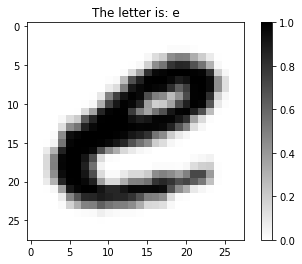

In [ ]:
# Randomly show image from training dataset
show_data(train_x_letters, train_y_letters, digit = False)

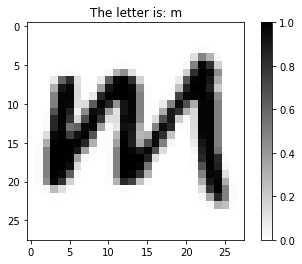

In [ ]:
# Randomly show image from testing dataset
show_data(test_x_letters, test_y_letters, digit = False)


In [ ]:
# Adjust shapes of data

# train set / data 
train_x_letters = np.expand_dims(train_x_letters, axis=-1)

# validation set / data 
test_x_letters = np.expand_dims(test_x_letters, axis=-1)

show_shapes(train_x_letters, train_y_letters, test_x_letters, test_y_letters, False)

Mnist  Alphabet  Dataset shapes: 
train X:  (124800, 28, 28, 1)
train Y:  (124800,)
test X:  (20800, 28, 28, 1)
test Y:  (20800,)


## **Mnist Digits**

In [ ]:
# Load MNIST dataset using tensorflow

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

show_shapes(x_train, y_train, x_test, y_test)

# x_train.shape, y_train.shape: (60000, 28, 28) (60000,)
# x_test.shape,  y_test.shape : (10000, 28, 28) (10000,)

11501568/11490434 [==============================] - 0s 0us/step
Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28)
train Y:  (60000,)
test X:  (10000, 28, 28)
test Y:  (10000,)


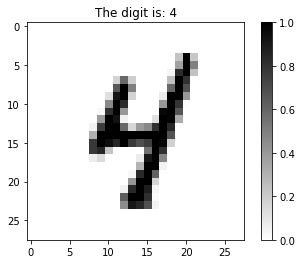

In [ ]:
show_data(x_train, y_train)

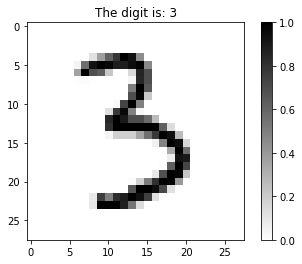

In [ ]:
show_data(x_test, y_test)

In [ ]:
# Adjust shapes of data

# train set / data 
x_train = np.expand_dims(x_train, axis=-1)

# validation set / data 
x_test = np.expand_dims(x_test, axis=-1)

show_shapes(x_train, y_train, x_test, y_test)

Mnist  Digit  Dataset shapes: 
train X:  (60000, 28, 28, 1)
train Y:  (60000,)
test X:  (10000, 28, 28, 1)
test Y:  (10000,)


# **Initialize model**

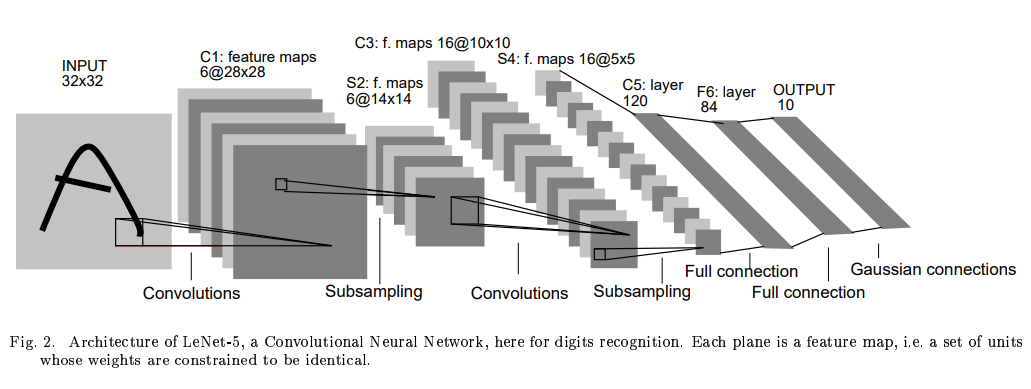

LeCun et al. (1998)

In [ ]:
from tensorflow.keras import Model, layers, Input, optimizers

In [ ]:
# Create a LeNet 5 model class

class LeNetFive(Model):
    def __init__(self, num_classes, name=''):
        super(LeNetFive, self).__init__()
        self.modelName = name
        self.inputSz = (32, 32, 1)

        # define all layers in init

        #Preprocess
        self.reshapeInp = layers.Resizing(self.inputSz[0], self.inputSz[0], name='resize_input')

        # Input layer
        layers.InputLayer(input_shape=(self.inputSz), name='Input')

        # First Convolutional Layer
        self.conv1 = layers.Conv2D(filters=6, kernel_size=5, strides=1, activation='tanh', name='c1')
        self.avg_pool1  = layers.AveragePooling2D(pool_size=2, strides=2, name='s2')

        # Second Convolutional Layer
        self.conv2 = layers.Conv2D(filters=16, kernel_size=5, strides=1, activation='tanh', name='c3')
        self.avg_pool2  = layers.AveragePooling2D(pool_size=2, strides=2, name='s4')

        # Fully connected layers
        self.conv3 = layers.Conv2D(120, 5, activation='tanh', name='c5')
        self.flat = layers.Flatten(name='flat')
        self.dense1 = layers.Dense(84, activation='tanh', name='f6')
        self.dense2 = layers.Dense(num_classes, activation='softmax', name='output')


    def call(self, input_tensor, training=False):
        x = self.reshapeInp(input_tensor)

        # forward pass: First layer 
        x = self.conv1(x)
        x = self.avg_pool1(x)

        # forward pass: Second layer 
        x = self.conv2(x)
        x = self.avg_pool2(x)

        # Fully connected layers
        x = self.conv3(x)
        x = self.flat(x)
        x = self.dense1(x)
        return self.dense2(x)

    def leNetModel(self):
        # Model attributes to tf Model class

        self.inpTensor = Input(shape=(28,28,1), name='InputLayer')
        x1 = self.inpTensor
        return Model(inputs=[x1], outputs=self.call(x1), name=self.modelName)

## Instantiate and Train LesNet5 for Digit classification

In [ ]:
# instantiate model object
model_digits = LeNetFive(10, 'LeNet_for_digits').leNetModel()

# print summary
model_digits.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
resize_input (Resizing)      (None, 32, 32, 1)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
s2 (AveragePooling2D)        (None, 14, 14, 6)         0         
_________________________________________________________________
c3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
s4 (AveragePooling2D)        (None, 5, 5, 16)          0         
_________________________________________________________________
c5 (Conv2D)                  (None, 1, 1, 120)    

In [ ]:
tf.keras.utils.plot_model(model_digits,show_shapes=True) 

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
model_digits.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

# fit 
history_digits = model_digits.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=32, epochs=20)
model_digits.evaluate(x_test, y_test)

Epoch 1/20
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0342 - accuracy: 0.9903 - val_loss: 0.0400 - val_accuracy: 0.9862
Epoch 2/20
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0327 - accuracy: 0.9905 - val_loss: 0.0394 - val_accuracy: 0.9883
Epoch 3/20
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0316 - accuracy: 0.9912 - val_loss: 0.0386 - val_accuracy: 0.9879
Epoch 4/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0303 - accuracy: 0.9917 - val_loss: 0.0374 - val_accuracy: 0.9876
Epoch 5/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0289 - accuracy: 0.9919 - val_loss: 0.0377 - val_accuracy: 0.9872
Epoch 6/20
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0279 - accuracy: 0.9923 - val_loss: 0.0380 - val_accuracy: 0.9873
Epoch 7/20
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0269 - accuracy: 0.9924 - val_loss: 0.0370 - v

[0.03379328176379204, 0.9879000186920166]

### Model accuracy and model loss of LeNet5 for digit classification

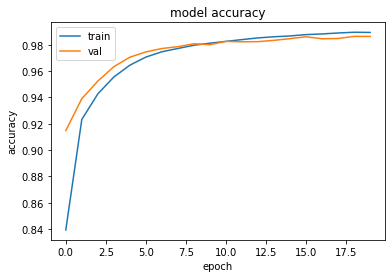

In [ ]:
plot_accuracy(history_digits)

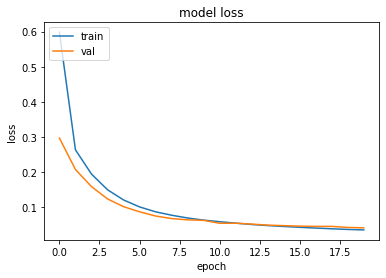

In [ ]:
plot_loss(history_digits)

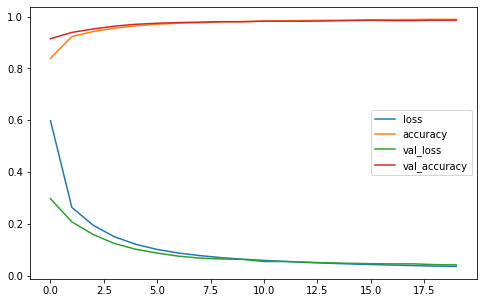

In [ ]:
pd.DataFrame(history_digits.history).plot(figsize=(8,5))
plt.show()

## Instantiate and Train for Alphabet classification

In [ ]:
# instantiate model object
model_letters = LeNetFive(27, 'LeNet_for_Alphabets').leNetModel()

# print summary
model_letters.summary()

Model: "LeNet_for_Alphabets"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (InputLayer)      [(None, 28, 28, 1)]       0         
_________________________________________________________________
resize_input (Resizing)      (None, 32, 32, 1)         0         
_________________________________________________________________
c1 (Conv2D)                  (None, 28, 28, 6)         156       
_________________________________________________________________
s2 (AveragePooling2D)        (None, 14, 14, 6)         0         
_________________________________________________________________
c3 (Conv2D)                  (None, 10, 10, 16)        2416      
_________________________________________________________________
s4 (AveragePooling2D)        (None, 5, 5, 16)          0         
_________________________________________________________________
c5 (Conv2D)                  (None, 1, 1, 120) 

In [ ]:
tf.keras.utils.plot_model(model_letters,show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [ ]:
model_letters.compile(
    optimizer = 'SGD',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])
# fit 
history_letters = model_letters.fit(train_x_letters, train_y_letters, validation_data=(test_x_letters, test_y_letters), batch_size=32, epochs=20)
model_letters.evaluate(test_x_letters, test_y_letters)

Epoch 1/20
3900/3900 [==============================] - 250s 64ms/step - loss: 1.3390 - accuracy: 0.6392 - val_loss: 0.8167 - val_accuracy: 0.7681
Epoch 2/20
3900/3900 [==============================] - 39s 10ms/step - loss: 0.6512 - accuracy: 0.8134 - val_loss: 0.5333 - val_accuracy: 0.8452
Epoch 3/20
3900/3900 [==============================] - 39s 10ms/step - loss: 0.4578 - accuracy: 0.8639 - val_loss: 0.4092 - val_accuracy: 0.8773
Epoch 4/20
3900/3900 [==============================] - 39s 10ms/step - loss: 0.3671 - accuracy: 0.8883 - val_loss: 0.3476 - val_accuracy: 0.8919
Epoch 5/20
3900/3900 [==============================] - 40s 10ms/step - loss: 0.3181 - accuracy: 0.9014 - val_loss: 0.3141 - val_accuracy: 0.9006
Epoch 6/20
3900/3900 [==============================] - 40s 10ms/step - loss: 0.2877 - accuracy: 0.9095 - val_loss: 0.2913 - val_accuracy: 0.9079
Epoch 7/20
3900/3900 [==============================] - 40s 10ms/step - loss: 0.2654 - accuracy: 0.9162 - val_loss: 0.2787 

[0.21968474984169006, 0.9258654117584229]

### Model accuracy and model loss of LeNet5 for alphabet classification

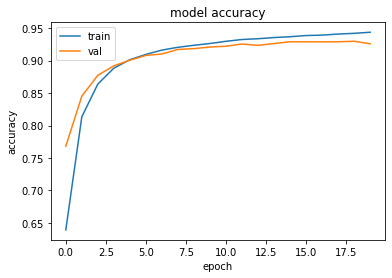

In [ ]:
plot_accuracy(history_letters)

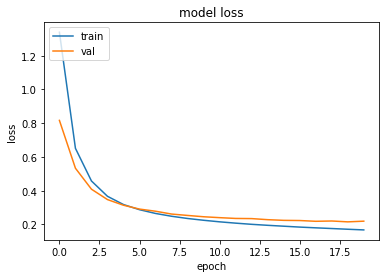

In [ ]:
plot_loss(history_letters)

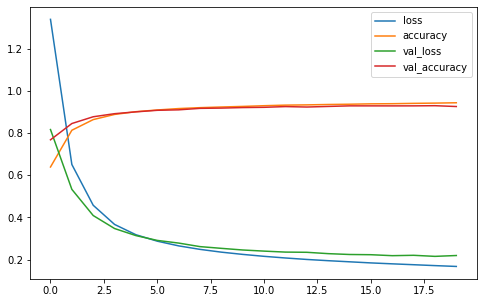

In [ ]:
pd.DataFrame(history_letters.history).plot(figsize=(8,5))
plt.show()

# **Saving and loading trained models**

In [ ]:
!git clone https://github.com/eliasezar27/LeNet5_implemetation.git

Cloning into 'LeNet5_implemetation'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 2), reused 6 (delta 2), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
model_dir = 'LeNet5_implemetation'

## LeNet5 for digits classification

In [ ]:
# To save the trained model
model_digits.save('model_digits.h5')

# To save the trained weights
model_digits.save_weights('model_digits_weights.h5')

In [ ]:
# To load the trained model
new_model2 = tf.keras.models.load_model(os.path.join(model_dir, 'model_digits.h5')) 

# To load the trained weights to the model used
# digits_model.load_weights('model_digits_weights.h5')

new_model2.summary()

Model: "LeNet_for_digits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120)    

## LeNet5 for alphabet classification

In [ ]:
# To save the trained model
model_letters.save('letters_model.h5')

# To save the trained weights
model_letters.save_weights('letters_model_weights.h5')

In [ ]:
# To load the trained model
new_model = tf.keras.models.load_model(os.path.join(model_dir, 'letters_model.h5'))

# To load the trained weights to the model used
# letters_model.load_weights('letters_model_weights.h5')

new_model.summary()

Model: "LeNet_for_Alphabets"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 28, 28, 1)]       0         
                                                                 
 resize_input (Resizing)     (None, 32, 32, 1)         0         
                                                                 
 c1 (Conv2D)                 (None, 28, 28, 6)         156       
                                                                 
 s2 (AveragePooling2D)       (None, 14, 14, 6)         0         
                                                                 
 c3 (Conv2D)                 (None, 10, 10, 16)        2416      
                                                                 
 s4 (AveragePooling2D)       (None, 5, 5, 16)          0         
                                                                 
 c5 (Conv2D)                 (None, 1, 1, 120) 